In [13]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import os
from pathlib import Path

In [14]:

__file__ = os.getcwd()
data_dir = Path(__file__).resolve().parents[1] / "Data" / "inaturalist_12K" / "Train"

In [15]:
batch_size = 32
img_height = 180
img_width = 180

In [16]:

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9999 files belonging to 10 classes.
Using 8000 files for training.


In [17]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9999 files belonging to 10 classes.
Using 1999 files for validation.


In [18]:
class_names = train_ds.class_names
print(class_names)

['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


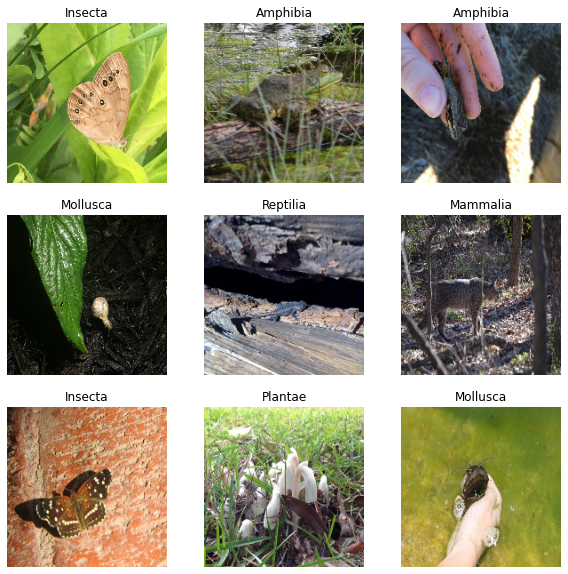

In [19]:
# Visualize the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
def model_creation(cnn_params, ff_params, img_height, img_width, nr_classes):

  model = models.Sequential()
  model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
  for param in cnn_params:
      nr_filter = param[0]
      size_filter = param[1]
      filter_activation = param[2]
      model.add(layers.Conv2D(nr_filter, (size_filter,size_filter), activation= filter_activation))
      model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(ff_params[0], activation=ff_params[1]))
  model.add(layers.Dense(nr_classes))
  
  return model


In [23]:
# cnn_param = [nr of filter, size of filter, activation]
cnn_params = [[32,3,'relu'],[32,3,'relu'],[32,3,'relu'],[32,3,'relu'],[32,3,'relu']]

# ff_param = [nr of neurons, activation]
ff_params = [256,'relu']

input_size  = (img_height, img_width)
nr_classes = len(class_names)
model = model_creation(cnn_params,ff_params,img_height, img_width, nr_classes)



In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9

In [25]:
# Number of computations(multiplication)
# for one layer -------------> outputshape * (size of filter * input channels)
# Eg: Layer 1
#     Input shape = 32 * 32 * 3
#     Size of filter = 3 * 3
#     Actual filter dim = size of filter * input channels = 3 * 3 * 3
#     No of filter   = 16
#     Output shape     = 30 * 30 * 16
#     So number of multiplication = (30 * 30 * 16) * (3*3*3) = 3,88,800

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
250/250 [==============================] - 150s 140ms/step - loss: 2.2512 - accuracy: 0.1476 - val_loss: 2.2020 - val_accuracy: 0.1846
Epoch 2/10
250/250 [==============================] - 10s 41ms/step - loss: 2.1872 - accuracy: 0.1876 - val_loss: 2.1517 - val_accuracy: 0.2006
Epoch 3/10
250/250 [==============================] - 10s 41ms/step - loss: 2.1172 - accuracy: 0.2288 - val_loss: 2.0960 - val_accuracy: 0.2306
Epoch 4/10
250/250 [==============================] - 10s 41ms/step - loss: 2.0501 - accuracy: 0.2573 - val_loss: 2.0306 - val_accuracy: 0.2701
Epoch 5/10
250/250 [==============================] - 10s 41ms/step - loss: 1.9766 - accuracy: 0.2977 - val_loss: 1.9891 - val_accuracy: 0.3027
Epoch 6/10
250/250 [==============================] - 10s 41ms/step - loss: 1.9198 - accuracy: 0.3085 - val_loss: 1.9551 - val_accuracy: 0.3007
Epoch 7/10
250/250 [==============================] - 10s 41ms/step - loss: 1.8607 - accuracy: 0.3411 - val_loss: 1.9373 - val_accurac